In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=95b48844b7904b81b912a5a3ec5289024d73a51a7b092cb646f2f5e9ad546318
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
import os
import re
from pathlib import Path
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import random
import wget
random.seed()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from string import punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
filename = wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/20_newsgroups.zip", "20_newsgroups.zip")
!unzip 20_newsgroups.zip
DATA_DIR = "20_newsgroups"

Streaming output truncated to the last 5000 lines.
  inflating: 20_newsgroups/talk.politics.guns/54127  
  inflating: 20_newsgroups/talk.politics.guns/53302  
  inflating: 20_newsgroups/talk.politics.guns/54315  
  inflating: 20_newsgroups/talk.politics.guns/54771  
  inflating: 20_newsgroups/talk.politics.guns/54543  
  inflating: 20_newsgroups/talk.politics.guns/55233  
  inflating: 20_newsgroups/talk.politics.guns/55039  
  inflating: 20_newsgroups/talk.politics.guns/54749  
  inflating: 20_newsgroups/talk.politics.guns/55234  
  inflating: 20_newsgroups/talk.politics.guns/54782  
  inflating: 20_newsgroups/talk.politics.guns/54544  
  inflating: 20_newsgroups/talk.politics.guns/54312  
  inflating: 20_newsgroups/talk.politics.guns/54120  
  inflating: 20_newsgroups/talk.politics.guns/53305  
  inflating: 20_newsgroups/talk.politics.guns/54915  
  inflating: 20_newsgroups/talk.politics.guns/54129  
  inflating: 20_newsgroups/talk.politics.guns/54586  
  inflating: 20_newsgroups/talk

## Functions from lab

In [4]:
def clean_file_text(text):
    new_text = re.sub("Newsgroups:.*?\n", "", text)
    new_text = re.sub("Xref:.*?\n", "", new_text)
    new_text = re.sub("Path:.*?\n", "", new_text)
    new_text = re.sub("Date:.*?\n", "", new_text)
    new_text = re.sub("Followup-To:.*?\n", "", new_text)
    return new_text

In [5]:
def corpus_count_words(file_list):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            word_counter.update(file_words)
    return word_counter

In [6]:
def get_topic_name(file_path):
    return file_path.parent.name

def get_target(topic_name):
    topics = ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 
     'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 
     'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
     'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']
    return topics.index(topic_name)

In [7]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

## Q1

In [8]:
all_files = [pth for pth in Path(DATA_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [9]:
def binary_baseline_data(file_list, num_words = 1000):
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    return X, y

In [10]:
# get the baseline data
X, y = binary_baseline_data(all_files)

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9472744159462742
Test accuracy: 0.6776666666666666


### Q1 (a)
**1. Feature Set is the most common words appearing in the all files.**
**2. The amount of data is 19997 files which are split in to training set(70%) and test set(30%).**
**3. The hyperparameters use in this baseline is C which defalut value is 1.0 in logistic regression. C(inverse regularization parameter) = 1/lambda, C is large will lead to overfit(weaker regularization when lambda is small) and C is small will lead to underfit(stronger regularization when lambda is large).**

### Q1 (b)

Modify the following function:

In [11]:
def corpus_count_improved_words(file_list):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    ps = LancasterStemmer()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data.lower())
            file_words = tokenizer.tokenize(file_data)
            file_words = [ps.stem(word) for word in file_words if word not in stopwords.words('english')]
            word_counter.update(file_words)
    return word_counter

In [12]:
def binary_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below

    # Calculate word count in corpus
    news_cnt = corpus_count_improved_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    ps = LancasterStemmer()
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data.lower())
            file_words = [ps.stem(word) for word in file_words if word not in stopwords.words('english')]
            df_rows.append([1 if word in file_words else 0 for word in word_list])
    X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = word_list)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]

    #Please remember to put index for your dataframe as the file name
    #For example: pd.DataFrame(data, index=[str(f) for f in file_list],columns=[])
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q1 (c)

Modify the following partial code to calculate the train and test accuracy and answer the question in the markdown cell below

In [13]:
# get the baseline data
X, y = binary_improved_data(all_files)

# Write your code here:
# You need to split the data and train a logistic regression classifier.
# Then, you need to calculate the variables train_accuracy and test_accuracy for the new classifier
# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9609916410659427
Test accuracy: 0.7293333333333333


**Both training accuracy and Test accuracy increase.**

### Q1 (d)

Modify the partial code below

In [24]:
def random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    for i in range(num_tests):
        # split to train and test set and try diff random state
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

        # train a logistic regression classifier
        clf = LogisticRegression(C=1.0).fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        # calculate train and test accuracy and appended to train_results and test_results
        train_results.append(accuracy_score(y_train, y_train_predict))
        test_results.append(accuracy_score(y_test, y_test_predict))
        
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

In [29]:
X, y = binary_improved_data(all_files)

### Q1 (e)

Use the following code to calculate the mean accuracy and 95% confidence interval over 10 random splits

In [34]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9611845395441879
Train confidence interval over 10 random splits: [0.9606468667936128, 0.9617222122947631]
Test mean accuracy over 10 random splits: 0.7384333333333334
Test confidence interval over 10 random splits: [0.7352593390181953, 0.7416073276484715]


**Average accuracy tell us the mean accuracy of train set and test set of 10 random splits.** **And 95% confidence intervals tell us 95% of experiments will include true mean in range of 95% confidence intervals.**
**They are more informative than a single trial since more experiments will reduce bias.**

### Q1 (f)

Modify the partial code below

In [16]:
def random_cm(X, y, num_tests):
    # cm_list is a list of confusion matrices for the different random splits of the dataset
    cm_list = []

    # Write your code here
    for i in range(num_tests):
        # split to train and test set and try diff random state
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

        # train a logistic regression classifier
        clf = LogisticRegression(C=1.0).fit(X_train, y_train)

        # predict on test set
        y_test_predict = clf.predict(X_test)

        cm_list.append(confusion_matrix(y_test, y_test_predict))
    # sum the confusion matrices and return the combined confusion matrix
    combined_cm = np.array(cm_list).sum(axis=0)

    # validate return type
    assert isinstance(combined_cm, np.ndarray), "return type"
    
    return combined_cm

### Q1 (g)

Use the following code to produce a confusion matrix for 10 random splits

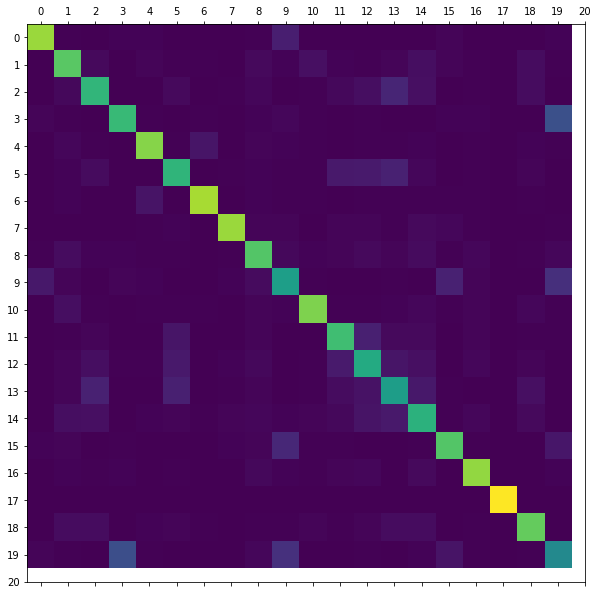

In [17]:
cm10 = random_cm(X, y, num_tests = 10)
plot_confusion_matrix(cm10)

**3 and 19 are easily confused with each other, 3 is about atheism and 19 is about religion. Since they are quite similar, both relate to religion.**

## Q2

### Q2 (a)

Modify the partial code below

In [18]:
def feature_num(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for p in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
        subset_size = int(p*X.shape[1])
        X_train_subset = X_train.iloc[:, 0:subset_size]
        X_test_subset = X_test.iloc[:, 0:subset_size]
        # Write your code here to calculate train_accuracy and test_accuracy for the current subset of features
        # ......
        clf = LogisticRegression(C=1.0).fit(X_train_subset, y_train)
        y_train_subset_predict = clf.predict(X_train_subset)
        y_test_subset_predict = clf.predict(X_test_subset)
        train_accuracy = accuracy_score(y_train, y_train_subset_predict)
        test_accuracy = accuracy_score(y_test, y_test_subset_predict)
        # add to result_list
        result_list.append((p, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["num_features", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q2 (b)

Use the following code to plot the train and test accuracy for the different feature sets sizes

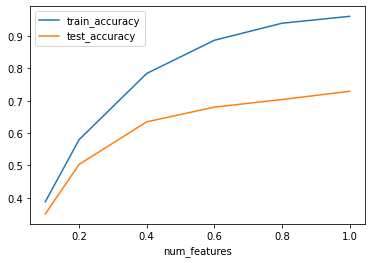

In [19]:
feature_num_df = feature_num(X, y)
feature_num_df.plot(x="num_features", y=["train_accuracy", "test_accuracy"])

**As number of featuers increases, both train accuracy and test accuracy are increasing.**

## Q3

### Q3 (a)

Modify the partial code below

In [20]:
def hyperparameter(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        # Write your code here to calculate train_accuracy and test_accuracy for the current parameter value
        # ......
        # train a logistic regression classifier
        clf = LogisticRegression(C=param).fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        
        # add to result_list
        result_list.append((param, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q3 (b)

Use the following code to plot the train and test accuracy for the different the parameters

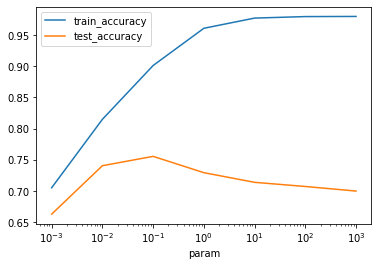

In [21]:
param_df = hyperparameter(X, y)
param_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

**As C increases, it will penalize less against overfitting. Thus, train accuracy increase, but test accuracy increase at first and decrease after. Since the model become more complex as C is increase, and model becomes overfitting when C is too large. From the plot figure, we see that C = 0.1 has the best performance in test set.**

## Q4

### Q4 (a)

Modify the partial code below

In [22]:
def tf_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    
    # Calculate word count in corpus
    news_cnt = corpus_count_improved_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    ps = LancasterStemmer()
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data.lower())
            file_words = Counter([ps.stem(word) for word in file_words if word not in stopwords.words('english')])
            df_rows.append([file_words[word] for word in word_list])
    
    X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = word_list)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q4 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [23]:
X_tf, y_tf = tf_improved_data(all_files)
train_mean100, train_low100, train_high100, test_mean100, test_low100, test_high100 = random_mean_ci(X_tf, y_tf, num_tests = 100)
print("Train mean accuracy over 100 random splits: {}".format(train_mean100))
print("Train confidence interval over 100 random splits: [{}, {}]".format(train_low100, train_high100))
print("Test mean accuracy over 100 random splits: {}".format(test_mean100))
print("Test confidence interval over 100 random splits: [{}, {}]".format(test_low100, test_high100))

Train mean accuracy over 100 random splits: 0.948580410087876
Train confidence interval over 100 random splits: [0.9475361810417681, 0.9496246391339839]
Test mean accuracy over 100 random splits: 0.7340883333333335
Test confidence interval over 100 random splits: [0.733026120203693, 0.735150546462974]


**It is non-overlapping 95% CI on average accuracy of TF and Binary Encoding. Binary Encoding: Train confidence interval over 10 random splits: [0.9606468667936128, 0.9617222122947631] Test confidence interval over 10 random splits: [0.7352593390181953, 0.7416073276484715].Both train accuracy and test accuracy with TF encoding method are less than train accuracy and test accuracy with binary encoding method. The reason may be that TF method weight more on hight frequency word, but some rare words may has higher information.**

## Q5

### Q5 (a)

Modify the partial code below

In [ ]:
def nb_random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    for i in range(num_tests):
        # split to train and test set and try diff random state
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

        # train a logistic regression classifier
        clf = MultinomialNB().fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        # calculate train and test accuracy and appended to train_results and test_results
        train_results.append(accuracy_score(y_train, y_train_predict))
        test_results.append(accuracy_score(y_test, y_test_predict))

    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q5 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [ ]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = nb_random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.7797099378438237
Train confidence interval over 10 random splits: [0.7781207103216573, 0.7812991653659901]
Test mean accuracy over 10 random splits: 0.7289833333333333
Test confidence interval over 10 random splits: [0.7259403013820493, 0.7320263652846173]


**It is non-overlapping 95% CI on average accuracy of Logistic regression and Naive Bayes. Logistic: Train confidence interval over 10 random splits: [0.9606468667936128, 0.9617222122947631] Test confidence interval over 10 random splits: [0.7352593390181953, 0.7416073276484715].
Logistic regression ran better than Naive Bayes on this dataset. Since NB's assumption is that features are independet with each other. In this dataset, those features are the most common words. However, the most common words have some relationships with each other.**

## Q6

### Q6 (a)

Modify the partial code below

In [ ]:
def binary_med_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    
    # Calculate word count in corpus
    news_cnt = corpus_count_improved_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    ps = LancasterStemmer()
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data.lower())
            file_words = [ps.stem(word) for word in file_words if word not in stopwords.words('english')]
            df_rows.append([1 if word in file_words else 0 for word in word_list])
  
    X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = word_list)
    y = [1 if get_topic_name(file_path) == 'sci.med' else 0 for file_path in file_list]

    #Please remember to put index for your dataframe as the file name
    #For example: pd.DataFrame(data, index=[str(f) for f in file_list],columns=[])

    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
  
    return X, y

### Q6 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [ ]:
X, y = binary_med_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9912767021504607
Train confidence interval over 10 random splits: [0.9908427364114893, 0.9917106678894321]
Test mean accuracy over 10 random splits: 0.9761000000000001
Test confidence interval over 10 random splits: [0.9753067502682686, 0.9768932497317315]


**Both train accuracy and test accuracy in binary classification are higher than multi-classification. Since 'sci.med' is label as 1, and the rest of 19 labels are all labels as 0. Data may become imbalance. In general, binary labels are easily to classify than multi labels, but in this case, data may become imbalance. We cannot just look at accuracy to say Binary classification works better than multi-classification.**

#Q7

##Q7(a)

use the following code cell to implement your feature encoding

In [ ]:
def data_q7(file_list, num_words = 10000):
  
  # Calculate word count in corpus
  news_cnt = corpus_count_improved_words(file_list)
  
  # Select the most common numWords
  word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
  
  # Create a binary encoding of dataset based on the selected features (X)
  tokenizer = RegexpTokenizer(r'\w+')
  ps = LancasterStemmer()
  # ps = WordNetLemmatizer()
  df_rows = []
  for file_path in file_list:
      with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
          file_data = file.read()
          file_data = clean_file_text(file_data)
          file_data = file_data.lower()
          # file_data = "".join(i for i in file_data if i not in string.punctuation)
          file_words = tokenizer.tokenize(file_data)
          file_words = [ps.stem(word) for word in file_words if word not in stopwords.words('english')]
          df_rows.append([1 if word in file_words else 0 for word in word_list])
          # df_rows.append([file_words[word] for word in file_words.keys() if word in word_list])
  
  X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = word_list)
  y = [get_target(get_topic_name(file_path)) for file_path in file_list]
  
  #Please remember to put index for your dataframe as the file name
  #For example: pd.DataFrame(data, index=[str(f) for f in file_list],columns=[])
  
  # validate return types
  assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
  
  return X, y

In [ ]:
# def data_q7(file_list, num_words = 10000):
#     # Make sure you update the variable features and targets below
    
#     # Calculate word count in corpus
#     news_cnt = corpus_count_improved_words(file_list)
    
#     # Select the most common numWords
#     word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
#     # Create a binary encoding of dataset based on the selected features (X)
#     tokenizer = RegexpTokenizer(r'\w+')
#     ps = LancasterStemmer()
#     df_rows = []
#     for file_path in file_list:
#         with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
#             file_data = file.read()
#             file_data = clean_file_text(file_data)
#             file_words = tokenizer.tokenize(file_data.lower())
#             file_words = Counter([ps.stem(word) for word in file_words if word not in stopwords.words('english')])
#             df_rows.append([file_words[word] for word in word_list])
    
#     X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = word_list)
#     y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
#     # validate return types
#     assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
#     return X, y

##Q7(b)

Use the following code cell to implement your model

In [ ]:
def build_model_q7():
  #write your code here, define your model
  MODELQ7=LogisticRegression(C=0.1)
  return MODELQ7

Code for evaluating p at k 

In [ ]:
def calculate_average_precision_at_k(MODELQ7, all_files, training_files, testing_files,k=None):
  
  training_files = [str(f) for f in open(training_files,mode='r').read().splitlines()]
  testing_files = [str(f) for f in open(testing_files,mode='r').read().splitlines()]
  if k is None:
    k=len(testing_files)

  X, y = data_q7(all_files) 
  X['gt'] = y
  training = X.loc[training_files]
  X_train = training.loc[:,training.columns!='gt']
  y_train = training['gt'].values

  testing = X.loc[testing_files]
  X_test = testing.loc[:,testing.columns!='gt']
  y_test = testing['gt'].values

  MODELQ7.fit(X_train,y_train)
  y_pred = MODELQ7.predict(X_test)
  y_pred_prob = MODELQ7.predict_proba(X_test)
  confidences = np.max(y_pred_prob,axis=1)
  
  p_at_k = []
  rel_at_k = []
  confidence_order = np.argsort(confidences)
  for i in range(1,k+1):
    top_confidence = confidence_order[-i:]
    pred_top_i = y_pred[top_confidence]
    gt_top_i = np.array(y_test)[top_confidence]
    p_at_i = np.sum(pred_top_i == gt_top_i)/i
    rel_at_i = (pred_top_i[0] == gt_top_i[0])
    p_at_k.append(p_at_i)
    rel_at_k.append(rel_at_i)
  print('average precision at {} is {}'.format(k,np.dot(p_at_k,rel_at_k)/k))
  return np.dot(p_at_k,rel_at_k)/k

In [ ]:
# Example usage:
m = calculate_average_precision_at_k(build_model_q7(), all_files, 'training_files_Q7.txt', 'testing_files_Q7.txt')

average precision at 4000 is 0.7147842243506644


##Q7(c)

**1. Feature set: the most common 10000 words in dataset. Feature encoding: Binary encoding.**
**2. Logistic Regression with C = 0.1**
**The reason why I choose the most common 10000 words as Feature Set is that: In Q2, I found that the more number of features we have, the higher both train accuracy and test acuuracy we get. And actually in my experiment for Q7, the most common 10000 words did better than the most 1000 or 4000 or 5000 or 6000 words.**
**The reason why I choose Binary encoding as Feature Encoding is that: In Q4, I found that Binary encoding get higher in both train accuracy and test accuracy than TF. And in my experiment for Q7, Binary Encoding works better than TF.**
**The reason why I choose Logistic regression as classifier is that: In Q5, I found that Logistic regression work better on both train accuracy and test accuracy than NB. And in my experiment for Q7, Logistic regression work better than NB. And the reason why I choose C=0.1 in logistic regression is that C=0.1 has the best performance among C=[0.001, 0.01, 0.1, 1, 10 ,100, 1000]. And it also has the best performance in Q7.**
**The final AP performance that my choices attained is 0.7147842243506644.**
